In [8]:
import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image
import copy
import glob

In [3]:
class point:

    def __init__(self, x, y, data):
        #point data
        self.x = x
        self.y = y
        self.data = data

    def __repr__(self):
        return f'{{"x": {self.x}, "y": {self.y}}}'
    
# class square:

#     def __init__(self, x, y, l):
#         # square cell initializing
#         self.x = x
#         self.y = y
#         self.l = l
#         self.points = []

#     def __repr__(self):
#         return f'({self.x}, {self.y}, {self.l})'

#     def contains(self, point):
#         # checks if point falls within a cell
#         xcheck = self.x - (self.l / 2) <= point.x and self.x + (self.l / 2) >= point.x
#         ycheck = self.y - (self.l / 2) <= point.y and self.y + (self.l / 2) >= point.y
#         return xcheck and ycheck
    
class quadtree:

    def __init__(self, x, y, l):
        #initialize quadtree object
        self.x = x
        self.y = y
        self.l = l
        self.points = []
        self.divided = False
        self.topleft = None
        self.topright = None
        self.botleft = None
        self.botright = None
        self.parent = None
        self.flow = None
        self.mass = 0
        self.min_cost_child = None
        self.cost_to_parent = 0
        self.augment_cost = 0
        self.augment_path_cost = 0
        self.augment_mass = 0

    def contains(self, point):
        # checks if point falls within a cell
        xcheck = self.x - (self.l / 2) <= point.x and self.x + (self.l / 2) >= point.x
        ycheck = self.y - (self.l / 2) <= point.y and self.y + (self.l / 2) >= point.y
        return xcheck and ycheck

    def subdivide(self):
        #divide up the current cell
        x, y, l = self.x, self.y, self.l

        self.topleft = quadtree(x-l/4, y+l/4, l/2)
        self.topleft.parent = self

        self.topright = quadtree(x+l/4, y+l/4, l/2)
        self.topright.parent = self

        self.botleft = quadtree(x-l/4, y-l/4, l/2)
        self.botleft.parent = self

        self.botright = quadtree(x+l/4, y-l/4, l/2)
        self.botright.parent = self

        self.divided = True

        for point in self.points:
            leaf = self.topleft.insert(point)
            if leaf == None:
                leaf = self.topright.insert(point)
            if leaf == None:
                leaf = self.botleft.insert(point)
            if leaf == None:
                leaf = self.botright.insert(point)

        self.points = []

    def insert(self, point):
        #insert a point into the quadtree starting at root
        if not self.contains(point):
            return None
        elif self.divided:
            leaf = self.topleft.insert(point)
            if leaf == None:
                leaf = self.topright.insert(point)
            if leaf == None:
                leaf = self.botleft.insert(point)
            if leaf == None:
                leaf = self.botright.insert(point)
            return leaf
        elif len(self.points) == 0:
            self.points.append(point)
            return self
        else:
            self.subdivide()
            leaf = self.topleft.insert(point)
            if leaf == None:
                leaf = self.topright.insert(point)
            if leaf == None:
                leaf = self.botleft.insert(point)
            if leaf == None:
                leaf = self.botright.insert(point)
            return leaf

    def backward_insert(self, point):
        #insert a point into the quadtree bottom-up recursively starting at leaf

        leaf = self.insert(point)
        if leaf == None:
            return self.parent.backward_insert(point)
        
        return leaf

    def killemptychildren(self):
        #get rid of any cells that do not have points inisde
        if not self.divided and len(self.points) != 0:
            return

        if not self.topleft.divided and len(self.topleft.points) == 0:
            self.topleft = None
        else:
            self.topleft.killemptychildren()
        
        if not self.topright.divided and len(self.topright.points) == 0:
            self.topright = None
        else:
            self.topright.killemptychildren()

        if not self.botleft.divided and len(self.botleft.points) == 0:
            self.botleft = None
        else:
            self.botleft.killemptychildren()

        if not self.botright.divided and len(self.botright.points) == 0:
            self.botright = None
        else:
            self.botright.killemptychildren()

        

    def printsub(self):
        if self.divided is False and len(self.points) > 0:
            print((self.x, self.y, self.l))
            print(self.points)
        else:
            if self.topleft is not None:
                self.topleft.printsub()
            if self.topright is not None:
                self.topright.printsub()
            if self.botleft is not None:
                self.botleft.printsub()
            if self.botright is not None:
                self.botright.printsub()

    def getlistofpoints(self, lst):
        #gets list of points from a tree
        #input list in form of [[xcoords], [ycoords], [distribution]
        #colors are hard coded to work with 2 distributinos
        if self.divided is False and len(self.points) > 0:
            lst[0].append(self.points[0].x)
            lst[1].append(self.points[0].y)
            if min(self.points[0].data) > 0:
                lst[2].append(2)
            elif self.points[0].data[0] > 0:
                lst[2].append(0)
            elif self.points[0].data[1] > 0:
                lst[2].append(1)
            else:
                lst[2].append(1000)

            return lst
        if self.topleft is not None:
            lst = self.topleft.getlistofpoints(lst)
        if self.topright is not None:
            lst = self.topright.getlistofpoints(lst)
        if self.botleft is not None:
            lst = self.botleft.getlistofpoints(lst)
        if self.botright is not None:
            lst = self.botright.getlistofpoints(lst)
        
        return lst
    
    def getcellboundaries(self, lst):
        #returns info wiht correct format to print the line segments of the cells
        #format is list of lists [[[x1, x2],[x3,x4]],[[y1, y2],[y3,y4]]]
        
        
        line1x = [self.x - self.l / 2, self.x - self.l / 2]
        line1y = [self.y - self.l / 2, self.y + self.l / 2]
        lst[0].append(line1x)
        lst[1].append(line1y)

        line2x = [self.x - self.l / 2, self.x + self.l / 2]
        line2y = [self.y + self.l / 2, self.y + self.l / 2]
        lst[0].append(line2x)
        lst[1].append(line2y)

        line3x = [self.x + self.l / 2, self.x + self.l / 2]
        line3y = [self.y + self.l / 2, self.y - self.l / 2]
        lst[0].append(line3x)
        lst[1].append(line3y)

        line4x = [self.x - self.l / 2, self.x + self.l / 2]
        line4y = [self.y - self.l / 2, self.y - self.l / 2]
        lst[0].append(line4x)
        lst[1].append(line4y)

            
        
        if self.topleft is not None:
            lst = self.topleft.getcellboundaries(lst)
        if self.topright is not None:
            lst = self.topright.getcellboundaries(lst)
        if self.botleft is not None:
            lst = self.botleft.getcellboundaries(lst)
        if self.botright is not None:
            lst = self.botright.getcellboundaries(lst)

        return lst
    
    def plottree(self):
        #plots a quadtree, colors are hard coded for 2 distributions
        lstofpts = self.getlistofpoints([[],[],[]])

        qtreeboundaries = self.getcellboundaries([[],[]])

        for i in range(len(qtreeboundaries[0])):
            print("test")
            plt.plot(qtreeboundaries[0][i], qtreeboundaries[1][i], color="black")

        upperx = (self.x + self.l / 2) + .2 * abs(self.x + self.l / 2)
        uppery = (self.y + self.l / 2) + .2 * abs(self.y + self.l / 2)

        lowerx = (self.x - self.l / 2) - .2 * abs(self.x - self.l / 2)
        lowery = (self.y - self.l / 2) - .2 * abs(self.y - self.l / 2)
        dist1 = [[],[]]
        dist2 = [[],[]]
        bothdist = [[],[]]
        print(lstofpts)
        for i in range(len(lstofpts[0])):
            if lstofpts[2][i] == 0:
                dist1[0].append(lstofpts[0][i])
                dist1[1].append(lstofpts[1][i])
            elif lstofpts[2][i] == 1:
                dist2[0].append(lstofpts[0][i])
                dist2[1].append(lstofpts[1][i])
            else:
                bothdist[0].append(lstofpts[0][i])
                bothdist[1].append(lstofpts[1][i])
        plt.plot(dist1[0], dist1[1], 'ro', color="red")
        plt.plot(dist2[0], dist2[1], 'ro', color="blue")
        plt.plot(bothdist[0], bothdist[1], 'ro', color="purple")
        plt.axis((lowerx, upperx, lowery, uppery))
        plt.show()

def getboundingbox(lstofpts):
    #gets non randomly shifted minimum bounding box
    minx = float('inf')
    maxx = -float('inf')
    miny = float('inf')
    maxy = -float('inf')

    for pt in lstofpts:
        if pt.x < minx:
            minx = pt.x
        if pt.x > maxx:
            maxx = pt.x
        if pt.y < miny:
            miny = pt.y
        if pt.y > maxy:
            maxy = pt.y

    centerx = (minx + maxx)/2
    centery = (miny + maxy)/2
    length = max(maxx-minx, maxy-miny)

    return centerx, centery, length

In [4]:
def insert_list(qtree, points):
    #insert a list of points into the quadtree
    q = qtree
    for p in points:
        q = q.backward_insert(p)


In [5]:
def is_leaf(qtree):
    #returns true if node is leaf
    if qtree.divided == False:
        return True
    else:
        return False

In [29]:
def euclidean_dist(x1, x2, y1, y2):
    return math.sqrt((x2-x1)**2 + (y2-y1)**2)


def initialize(qtree, cost_func, k):
    global cost
    if qtree == None:
        return
    if is_leaf(qtree):
        pt = qtree.points[0]
        qtree.flow = np.array(pt.data)
        for m in pt.data:
            cost += m* cost_func(pt.x, qtree.x, pt.y, qtree.y)
        return
    
    initialize(qtree.topleft, cost_func, k)
    initialize(qtree.topright, cost_func, k)
    initialize(qtree.botleft, cost_func, k)
    initialize(qtree.botright, cost_func, k)
    qtree.flow = np.zeros(k)
    if qtree.topleft != None:
        qtree.flow += qtree.topleft.flow
        qtree.topleft.cost_to_parent = cost_func(qtree.x, qtree.topleft.x, qtree.y, qtree.topleft.y)
        cost += np.sum(qtree.topleft.flow * qtree.topleft.cost_to_parent)
    if qtree.topright != None:
        qtree.flow += qtree.topright.flow
        qtree.topright.cost_to_parent = cost_func(qtree.x, qtree.topright.x, qtree.y, qtree.topright.y)
        cost += np.sum(qtree.topright.flow * qtree.topright.cost_to_parent)
    if qtree.botleft != None:
        qtree.flow += qtree.botleft.flow
        qtree.botleft.cost_to_parent = cost_func(qtree.x, qtree.botleft.x, qtree.y, qtree.botleft.y)
        cost += np.sum(qtree.botleft.flow * qtree.botleft.cost_to_parent)
    if qtree.botright != None:
        qtree.flow += qtree.botright.flow
        qtree.botright.cost_to_parent = cost_func(qtree.x, qtree.botright.x, qtree.y, qtree.botright.y)
        cost += np.sum(qtree.botright.flow * qtree.botright.cost_to_parent)

def minimize_path_cost(qtree):
    qtree.augment_path_cost = 0
    if qtree.botleft != None:
        c = qtree.botleft.augment_path_cost + qtree.botleft.augment_cost
        if c < qtree.augment_path_cost:
            qtree.augment_path_cost = c
            qtree.min_cost_child = qtree.botleft
    if qtree.botright != None:
        c = qtree.botright.augment_path_cost + qtree.botright.augment_cost
        if c < qtree.augment_path_cost:
            qtree.augment_path_cost = c
            qtree.min_cost_child = qtree.botright
    if qtree.topleft != None:
        c = qtree.topleft.augment_path_cost + qtree.topleft.augment_cost
        if c < qtree.augment_path_cost:
            qtree.augment_path_cost = c
            qtree.min_cost_child = qtree.topleft
    if qtree.topright != None:
        c = qtree.topright.augment_path_cost + qtree.topright.augment_cost
        if c < qtree.augment_path_cost:
            qtree.augment_path_cost = c
            qtree.min_cost_child = qtree.topright

def update_augment_mass(qtree, k):
    qtree.augment_mass = 0
    if qtree.augment_path_cost < 0:
        mask = np.where(qtree.min_cost_child.flow > 0.000000000000001)
        nonzero_flow = qtree.min_cost_child.flow[mask]
        if len(nonzero_flow) == 0:
            return
        min_flow = np.min(nonzero_flow)
        if qtree.min_cost_child.augment_mass == 0:
            qtree.augment_mass = min_flow
        else:
            qtree.augment_mass = min(min_flow, qtree.min_cost_child.augment_mass)

def compute_augmenting_path(qtree, k):
    if qtree == None:
        return
    if is_leaf(qtree):
        k1 = len(np.where(qtree.flow > 0.000000000000001)[0])     # number of distributions with positive flow
        qtree.augment_cost = (k - 2*k1) * qtree.cost_to_parent
        return
    
    compute_augmenting_path(qtree.botleft, k)
    compute_augmenting_path(qtree.botright, k)
    compute_augmenting_path(qtree.topleft, k)
    compute_augmenting_path(qtree.topright, k)

    k1 = len(np.where(qtree.flow > 0.000000000000001)[0])      # number of distributions with positive flow
    qtree.augment_cost = (k - 2*k1) * qtree.cost_to_parent
    minimize_path_cost(qtree)
    update_augment_mass(qtree, k)

def push_flow(qtree, cost_func, k, push_mass):
    global barycenter

    if qtree.min_cost_child == None:
        # if is_leaf(qtree):
        #     cost -= push_mass * cost_func(qtree.x, qtree.points[0].x, 
        #                                   qtree.y, qtree.points[0].y) * positive_flow(qtree)
        qtree.mass = push_mass
        if (qtree.x, qtree.y) not in barycenter:
            barycenter[(qtree.x, qtree.y)] = 0
        barycenter[(qtree.x, qtree.y)] += qtree.mass
        qtree.flow -= push_mass
        k1 = len(np.where(qtree.flow > 0.000000000000001)[0])
        qtree.augment_cost = (k - 2*k1) * qtree.cost_to_parent
        return

    push_flow(qtree.min_cost_child, cost_func, k, push_mass)

    qtree.flow -= push_mass
    k1 = len(np.where(qtree.flow > 0.000000000000001)[0])
    qtree.augment_cost = (k - 2*k1) * qtree.cost_to_parent
    qtree.min_cost_child = None
    minimize_path_cost(qtree)
    update_augment_mass(qtree, k)

# def get_barycenter(qtree):
#     global barycenter
    
#     if qtree == None:
#         return
#     if qtree.mass > 0:
#         barycenter[(qtree.x, qtree.y)] = qtree.mass
#     get_barycenter(qtree.topleft)
#     get_barycenter(qtree.topright)
#     get_barycenter(qtree.botleft)
#     get_barycenter(qtree.botright)

def compute_barycenter(qtree, cost_func, k):
    global cost

    initialize(qtree, cost_func, k)
    print(qtree.topright.flow)
    print(qtree.botright.flow)
    qtree.mass = 1
    compute_augmenting_path(qtree, k)
    cost += qtree.augment_path_cost*qtree.augment_mass
    
    while qtree.augment_path_cost < -.000000000000001 and qtree.mass > 0.000000000000001:
        qtree.mass -= qtree.augment_mass
        push_flow(qtree, euclidean_dist, k, qtree.augment_mass)
        cost += qtree.augment_path_cost*qtree.augment_mass
    
 

In [30]:
cost = 0
testqtree = quadtree(0, 0, 4)
testqtree.insert(point(1, 1, [0.7106547513959407, 0.5883077126152989, 0.7106547513959407]))
testqtree.insert(point(1, -1, [0.2893452486040593, 0.4116922873847011, 0.2893452486040593]))
testqtree.killemptychildren()

compute_barycenter(testqtree, euclidean_dist, 3)
print(cost)
print(barycenter)
barycenter = {}
cost = 0
testqtree = quadtree(0, 0, 4)
testqtree.insert(point(1, 1, [0.5, .6, 0.5]))
testqtree.insert(point(1, -1, [0.5, .4, 0.5]))
testqtree.killemptychildren()

compute_barycenter(testqtree, euclidean_dist, 3)
print(cost)
print(barycenter)

[0.71065475 0.58830771 0.71065475]
[0.28934525 0.41169229 0.28934525]
0.3460496831195416
{(1.0, -1.0): 0.2893452486040593, (1.0, 1.0): 0.12234703878064179}
[0.5 0.6 0.5]
[0.5 0.4 0.5]
0.2828427124746191
{(1.0, -1.0): 0.09999999999999998, (1.0, 1.0): 0.5}


In [22]:
cost = 0
barycenter = {}

sq = (0, 0, 3)
qtree = quadtree(0,0,3)
qtree.insert(point(0, -1.5, [2/3, 1/3]))
qtree.insert(point(1, 1, [0, 2/3]))
qtree.insert(point(1, 1.01, [1/3, 0]))
qtree.killemptychildren()

qtree.printsub()
compute_barycenter(qtree, euclidean_dist, 2)
print(cost)
print(barycenter)

(0.99609375, 1.01953125, 0.0234375)
[{"x": 1, "y": 1.01}]
(0.99609375, 0.99609375, 0.0234375)
[{"x": 1, "y": 1}]
(-0.75, -0.75, 1.5)
[{"x": 0, "y": -1.5}]
2.133961015132144
{(1.0078125, 1.0078125): 0.3333333333333333, (-0.75, -0.75): 0.3333333333333333}


In [8]:
def normalize_image(im):
    s = np.sum(im)
    normalized_im = im/s
    return normalized_im

In [9]:
def getrandshift(lstofpts):
    #constructs the initial square for a random shift quadtree
    initx, inity, initlength = getboundingbox(lstofpts)
    minx = initx - initlength/2
    maxx = initx + initlength/2
    miny = inity - initlength/2
    maxy = inity + initlength/2

    shiftx = np.random.uniform(minx, maxx)
    shifty = np.random.uniform(miny, maxy)

    newlength = initlength*2
    
    return shiftx, shifty, newlength

In [10]:
def images_to_points(images):
    points = []
    m = 0
    n = 0
    for im in images:
        if im.shape[0] > m:
            m = im.shape[0]
        if im.shape[1] > n:
            n = im.shape[1]

    for i in range(len(images)):
        row_diff = m - images[i].shape[0]
        col_diff = n - images[i].shape[1]
        images[i] = np.pad(images[i], ((math.floor(row_diff/2), math.ceil(row_diff/2)), (math.floor(col_diff/2), math.ceil(col_diff/2))),
                    'constant', constant_values=0)

    for i in range(m):
        for j in range(n):
            p = point(i, j, [im[i][j] for im in images])
            points.append(p)
            
    return points, (m, n)

In [11]:
def plotbarycenter(barycenterdict, point_size, image_size):
    coords = barycenterdict.items()
    x = [pt[0][0] for pt in coords]
    y = [pt[0][1] for pt in coords]
    t = [pt[1] for pt in coords]
    # t = np.linspace(0, 1, len(x))
    fig, ax = plt.subplots()
    sc = ax.scatter(y, x, c=t, marker='.', s=point_size)
    fig.colorbar(sc, label="mass")
    plt.xlim(0, image_size[1])
    plt.ylim(0, image_size[0])
    plt.gca().invert_yaxis()
    plt.show()

0.3460496831195416
{(1.0, -1.0): 0.2893452486040593, (1.0, 1.0): 0.12234703878064179}
0.2828427124746191
{(1.0, -1.0): 0.4, (1.0, 1.0): 0.09999999999999998}


0.532383549520037


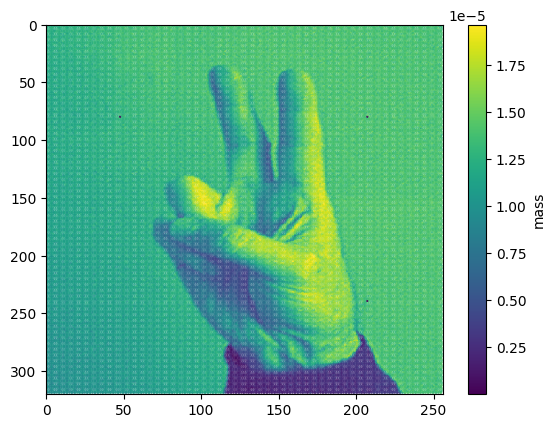

In [104]:
hand0 = np.array(Image.open("testing images/hand0.png")) #load image and get pixel values
normalized_hand0 = normalize_image(hand0)
identical_image_points, hand_size = images_to_points([normalized_hand0, normalized_hand0])

barycenter = {}
cost = 0
sq1_x, sq1_y, sq1_l = getboundingbox(identical_image_points)
qtree1 = quadtree(sq1_x, sq1_y, sq1_l)
insert_list(qtree1, identical_image_points)
qtree1.killemptychildren()
compute_barycenter(qtree1, euclidean_dist, 2)
print(cost)
plotbarycenter(barycenter, 1, hand_size)

116.76801829478686


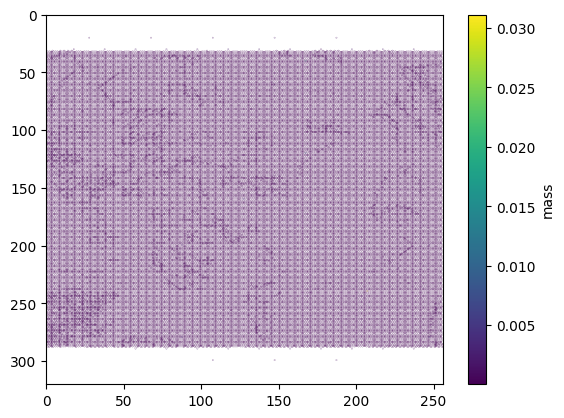

In [ ]:
#test on three different images

tree = tree = np.array(Image.open("testing images/tree.png").convert('L'))
normalized_tree = normalize_image(tree)
dog = np.array(Image.open("testing images/dog.png")) 
normalized_dog = normalize_image(dog)
different_image_points, size2 = images_to_points([normalized_hand0, normalized_tree, normalized_dog])

cost = 0
barycenter = {}
sq2_x, sq2_y, sq2_l = getboundingbox(different_image_points)
sq2 = square(sq2_x, sq2_y, sq2_l)
qtree2 = quadtree(sq2)
for p in different_image_points:
    qtree2.insert(p)
qtree2.killemptychildren()
compute_barycenter(qtree2, euclidean_dist, 3)
print(cost)
plotbarycenter(barycenter, 0.07, size2)

In [ ]:
print(int(hand0[1][36]) + int(dog[1][36]))
print(int(hand0[1][35]) + int(dog[1][35]))
print(hand0[0][35])
print(hand0[0][36])
print(hand0[36][0])
print(hand0[35][0])
print(hand0[35][1])
print(hand0[36][1])

340
368
158
169
153
149
152
159


5657.835065250874


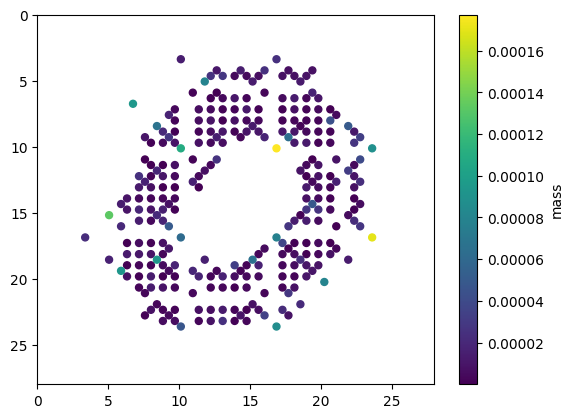

In [23]:
#test on mnist zeros

import glob
zero_images = []
for filename in glob.glob('testing images/mnist_zeros/*.png'): 
    im = np.array(Image.open(filename))
    normalized_im = normalize_image(im)
    zero_images.append(normalized_im)
zero_image_points, zero_image_size = images_to_points(zero_images)

cost = 0
barycenter = {}
mnist_sq_x, mnist_sq_y, mnist_sq_l = getboundingbox(zero_image_points)
mnist_qtree = quadtree(mnist_sq_x, mnist_sq_y, mnist_sq_l)
insert_list(mnist_qtree, zero_image_points)
# for p in zero_image_points:
#     mnist_qtree0.insert(p)
mnist_qtree.killemptychildren()
compute_barycenter(mnist_qtree, euclidean_dist, len(zero_images))
print(cost)
plotbarycenter(barycenter, 100, zero_image_size)

9556.618642019244


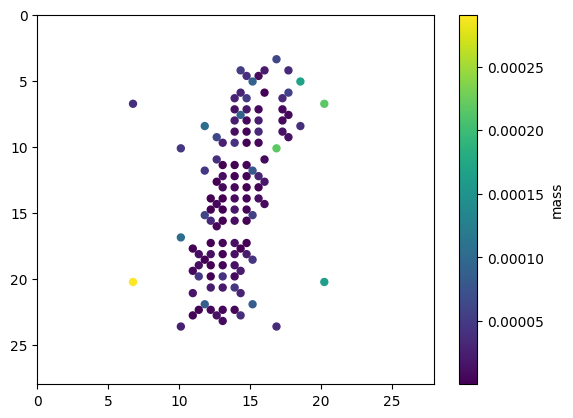

In [25]:
#test on mnist ones

one_images = []
for filename in glob.glob('testing images/mnist_ones/*.png'): 
    im = np.array(Image.open(filename))
    normalized_im = normalize_image(im)
    one_images.append(normalized_im)
one_image_points, one_image_size = images_to_points(one_images)

cost = 0
barycenter = {}
mnist_sq_x, mnist_sq_y, mnist_sq_l = getboundingbox(one_image_points)
mnist_qtree = quadtree(mnist_sq_x, mnist_sq_y, mnist_sq_l)
insert_list(mnist_qtree, one_image_points)
mnist_qtree.killemptychildren()
compute_barycenter(mnist_qtree, euclidean_dist, len(one_images))
print(cost)
plotbarycenter(barycenter, 100, one_image_size)

6997.153753475678


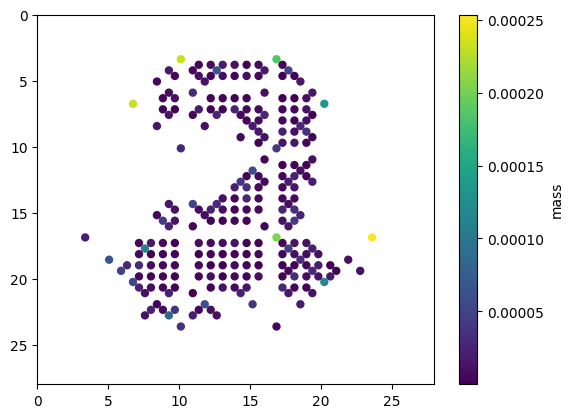

In [27]:
two_images = []
for filename in glob.glob('testing images/mnist_twos/*.png'): 
    im = np.array(Image.open(filename))
    normalized_im = normalize_image(im)
    two_images.append(normalized_im)
two_image_points, two_image_size = images_to_points(two_images)

cost = 0
barycenter = {}
mnist_sq_x, mnist_sq_y, mnist_sq_l = getboundingbox(two_image_points)
mnist_qtree = quadtree(mnist_sq_x, mnist_sq_y, mnist_sq_l)
insert_list(mnist_qtree, two_image_points)
mnist_qtree.killemptychildren()
compute_barycenter(mnist_qtree, euclidean_dist, len(two_images))
print(cost)
plotbarycenter(barycenter, 100, two_image_size)

6433.233876545499


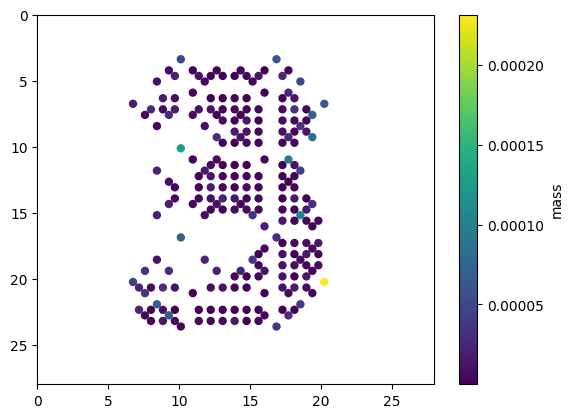

In [33]:
three_images = []
for filename in glob.glob('testing images/mnist_threes/*.png'): 
    im = np.array(Image.open(filename))
    normalized_im = normalize_image(im)
    three_images.append(normalized_im)
three_image_points, three_image_size = images_to_points(three_images)

cost = 0
barycenter = {}
mnist_sq_x, mnist_sq_y, mnist_sq_l = getboundingbox(three_image_points)
mnist_qtree = quadtree(mnist_sq_x, mnist_sq_y, mnist_sq_l)
insert_list(mnist_qtree, three_image_points)
mnist_qtree.killemptychildren()
compute_barycenter(mnist_qtree, euclidean_dist, len(three_images))
print(cost)
plotbarycenter(barycenter, 100, three_image_size)

6311.460116931293


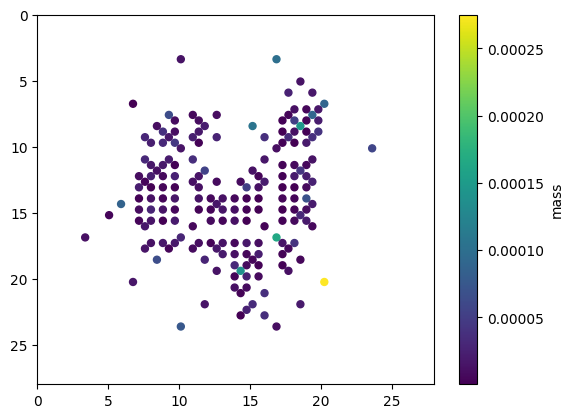

In [34]:
four_images = []
for filename in glob.glob('testing images/mnist_fours/*.png'): 
    im = np.array(Image.open(filename))
    normalized_im = normalize_image(im)
    four_images.append(normalized_im)
four_image_points, four_image_size = images_to_points(four_images)

cost = 0
barycenter = {}
mnist_sq_x, mnist_sq_y, mnist_sq_l = getboundingbox(four_image_points)
mnist_qtree = quadtree(mnist_sq_x, mnist_sq_y, mnist_sq_l)
insert_list(mnist_qtree, four_image_points)
mnist_qtree.killemptychildren()
compute_barycenter(mnist_qtree, euclidean_dist, len(four_images))
print(cost)
plotbarycenter(barycenter, 100, four_image_size)

6751.07430056894


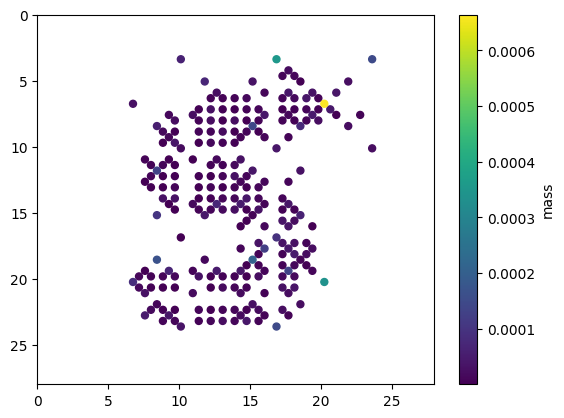

In [35]:
five_images = []
for filename in glob.glob('testing images/mnist_fives/*.png'): 
    im = np.array(Image.open(filename))
    normalized_im = normalize_image(im)
    five_images.append(normalized_im)
five_image_points, five_image_size = images_to_points(five_images)

cost = 0
barycenter = {}
mnist_sq_x, mnist_sq_y, mnist_sq_l = getboundingbox(five_image_points)
mnist_qtree = quadtree(mnist_sq_x, mnist_sq_y, mnist_sq_l)
insert_list(mnist_qtree, five_image_points)
mnist_qtree.killemptychildren()
compute_barycenter(mnist_qtree, euclidean_dist, len(five_images))
print(cost)
plotbarycenter(barycenter, 100, five_image_size)

6100.465533151416


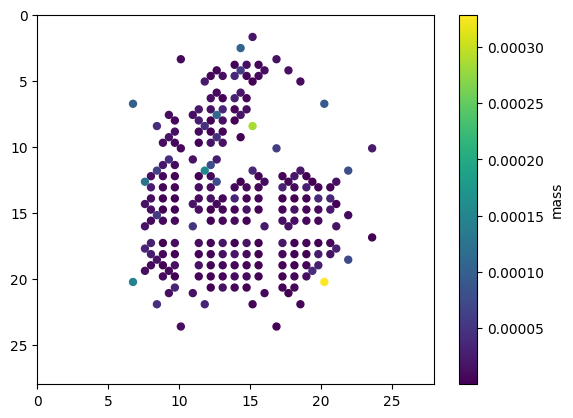

In [38]:
six_images = []
for filename in glob.glob('testing images/mnist_sixes/*.png'): 
    im = np.array(Image.open(filename))
    normalized_im = normalize_image(im)
    six_images.append(normalized_im)
six_image_points, six_image_size = images_to_points(six_images)

cost = 0
barycenter = {}
mnist_sq_x, mnist_sq_y, mnist_sq_l = getboundingbox(six_image_points)
mnist_qtree = quadtree(mnist_sq_x, mnist_sq_y, mnist_sq_l)
insert_list(mnist_qtree, six_image_points)
mnist_qtree.killemptychildren()
compute_barycenter(mnist_qtree, euclidean_dist, len(six_images))
print(cost)
plotbarycenter(barycenter, 100, six_image_size)

7361.992244331969


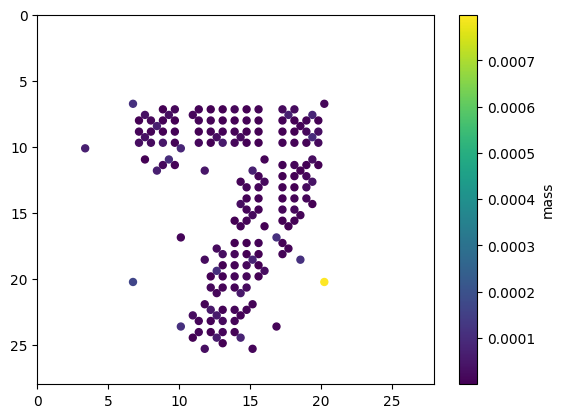

In [40]:
seven_images = []
for filename in glob.glob('testing images/mnist_sevens/*.png'): 
    im = np.array(Image.open(filename))
    normalized_im = normalize_image(im)
    seven_images.append(normalized_im)
seven_image_points, seven_image_size = images_to_points(seven_images)

cost = 0
barycenter = {}
mnist_sq_x, mnist_sq_y, mnist_sq_l = getboundingbox(seven_image_points)
mnist_qtree = quadtree(mnist_sq_x, mnist_sq_y, mnist_sq_l)
insert_list(mnist_qtree, seven_image_points)
mnist_qtree.killemptychildren()
compute_barycenter(mnist_qtree, euclidean_dist, len(seven_images))
print(cost)
plotbarycenter(barycenter, 100, seven_image_size)

5795.3484433397525


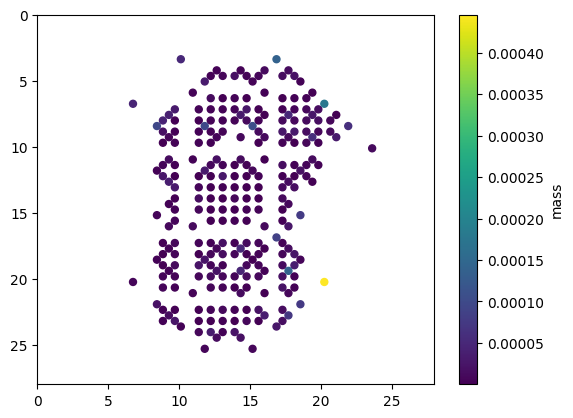

In [42]:
eight_images = []
for filename in glob.glob('testing images/mnist_eights/*.png'): 
    im = np.array(Image.open(filename))
    normalized_im = normalize_image(im)
    eight_images.append(normalized_im)
eight_image_points, eight_image_size = images_to_points(eight_images)

cost = 0
barycenter = {}
mnist_sq_x, mnist_sq_y, mnist_sq_l = getboundingbox(eight_image_points)
mnist_qtree = quadtree(mnist_sq_x, mnist_sq_y, mnist_sq_l)
insert_list(mnist_qtree, eight_image_points)
mnist_qtree.killemptychildren()
compute_barycenter(mnist_qtree, euclidean_dist, len(eight_images))
print(cost)
plotbarycenter(barycenter, 100, eight_image_size)

5999.2919411163375


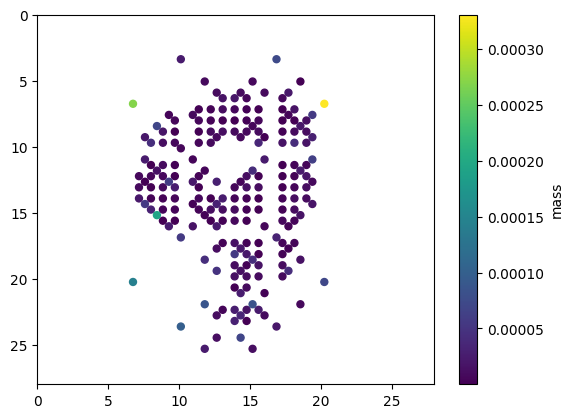

In [43]:
nine_images = []
for filename in glob.glob('testing images/mnist_nines/*.png'): 
    im = np.array(Image.open(filename))
    normalized_im = normalize_image(im)
    nine_images.append(normalized_im)
nine_image_points, nine_image_size = images_to_points(nine_images)

cost = 0
barycenter = {}
mnist_sq_x, mnist_sq_y, mnist_sq_l = getboundingbox(nine_image_points)
mnist_qtree = quadtree(mnist_sq_x, mnist_sq_y, mnist_sq_l)
insert_list(mnist_qtree, nine_image_points)
mnist_qtree.killemptychildren()
compute_barycenter(mnist_qtree, euclidean_dist, len(nine_images))
print(cost)
plotbarycenter(barycenter, 100, nine_image_size)

5937.266418442976


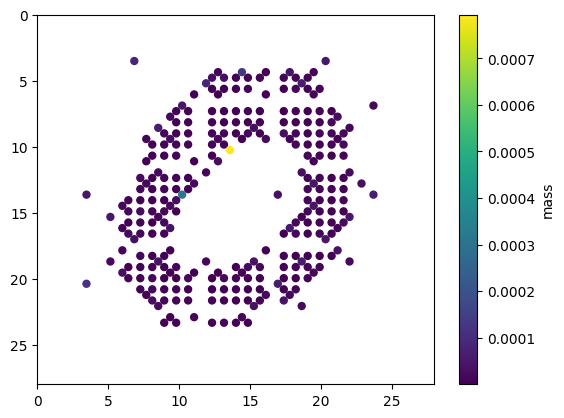

In [20]:
#test on mnist zeros with rand shift

zero_costs = []

zero_image_points, zero_image_size = images_to_points(zero_images)

mincost = float('inf')
bestbc = {}
for x in range(10):
    cost = 0
    barycenter = {}
    mnist_sq_x, mnist_sq_y, mnist_sq_l = getrandshift(zero_image_points)
    mnist_qtree = quadtree(mnist_sq_x, mnist_sq_y, mnist_sq_l)
    insert_list(mnist_qtree, zero_image_points)
    mnist_qtree.killemptychildren()
    compute_barycenter(mnist_qtree, euclidean_dist, len(zero_images))
    zero_costs.append(cost)
    if cost < mincost:
        mincost = cost
        bestbc = copy.deepcopy(barycenter)

print(mincost)
plotbarycenter(bestbc, 100, zero_image_size)

In [21]:
import statistics

print(zero_costs)
print(statistics.mean(zero_costs))
print(statistics.stdev(zero_costs))

[6793.875374483827, 7973.643591713491, 9192.660671543854, 6717.334681065381, 9786.844811577737, 7654.343650864502, 10834.018808510098, 8791.795157980483, 8054.859288836712, 5937.266418442976]
8173.664245501906
1507.3996229831228


5960.530997331803


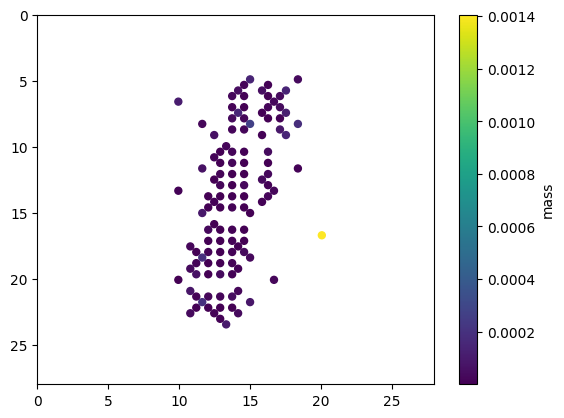

In [30]:
one_costs = []

one_image_points, one_image_size = images_to_points(one_images)

mincost = float('inf')
bestbc = {}
for x in range(10):
    cost = 0
    barycenter = {}
    mnist_sq_x, mnist_sq_y, mnist_sq_l = getrandshift(one_image_points)
    mnist_qtree = quadtree(mnist_sq_x, mnist_sq_y, mnist_sq_l)
    insert_list(mnist_qtree, one_image_points)
    mnist_qtree.killemptychildren()
    compute_barycenter(mnist_qtree, euclidean_dist, len(one_images))
    one_costs.append(cost)
    if cost < mincost:
        mincost = cost
        bestbc = copy.deepcopy(barycenter)

print(mincost)
plotbarycenter(bestbc, 100, one_image_size)

In [31]:
print(one_costs)

[6164.93361903303, 5960.530997331803, 7397.196750212958, 14504.975256839041, 9376.989027726218, 6657.148954607543, 13183.426424094512, 9156.8982555187, 11765.986374496066, 9081.025615419625]


7645.298052131778


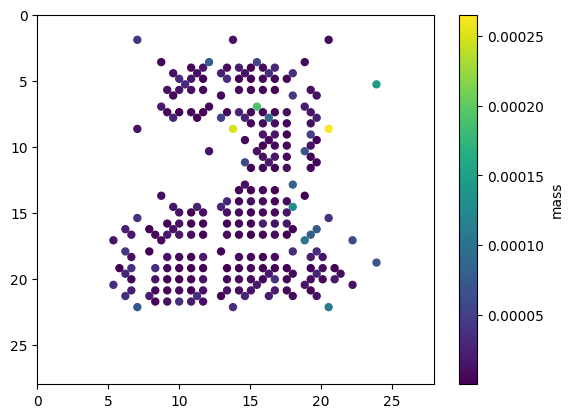

In [32]:
two_costs = []

two_image_points, two_image_size = images_to_points(two_images)

mincost = float('inf')
bestbc = {}
for x in range(10):
    cost = 0
    barycenter = {}
    mnist_sq_x, mnist_sq_y, mnist_sq_l = getrandshift(one_image_points)
    mnist_qtree = quadtree(mnist_sq_x, mnist_sq_y, mnist_sq_l)
    insert_list(mnist_qtree, two_image_points)
    mnist_qtree.killemptychildren()
    compute_barycenter(mnist_qtree, euclidean_dist, len(two_images))
    two_costs.append(cost)
    if cost < mincost:
        mincost = cost
        bestbc = copy.deepcopy(barycenter)

print(mincost)
plotbarycenter(bestbc, 100, two_image_size)

In [13]:
#load and preprocess large images

trump = np.array(Image.open("testing images/trump.png").convert('L'))
biden = np.array(Image.open("testing images/biden.png").convert('L'))
normalized_trump = normalize_image(trump)
normalized_biden = normalize_image(biden)
large_image_points, large_size = images_to_points([normalized_trump, normalized_biden])

In [105]:
#construct qtree for large images

cost = 0
barycenter = {}
large_sq_x, large_sq_y, large_sq_l = getboundingbox(large_image_points)
large_qtree = quadtree(large_sq_x, large_sq_y, large_sq_l)
insert_list(large_qtree, large_image_points)
large_qtree.killemptychildren()


In [106]:
compute_barycenter(large_qtree, euclidean_dist, 2)
print(cost)

KeyboardInterrupt: 

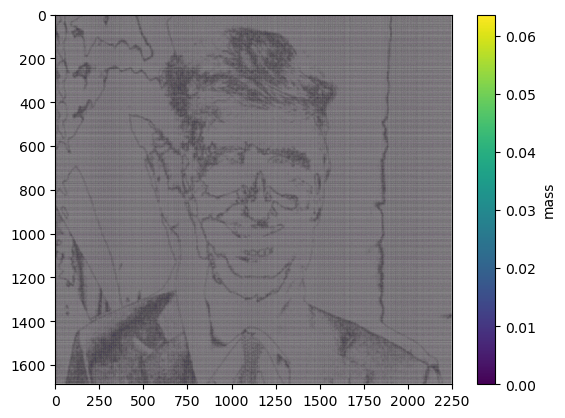

In [ ]:
plotbarycenter(barycenter, 0.00004, large_size)